Using TensorFlow backend.


{'arousal': [arousal    1.6
dtype: float64, arousal    8.1
dtype: float64], 'valence': [valence    1.6
dtype: float64, valence    8.4
dtype: float64]}
[[4.20411765]] [[4.34705882]]
[[4.85882353]] [[4.27058824]]
[[4.82941176]] [[4.91176471]]
[[5.02529412]] [[5.40588235]]
[[4.02941176]] [[4.61764706]]
[[5.48823529]] [[5.25294118]]


<Figure size 640x480 with 1 Axes>

<Figure size 640x480 with 1 Axes>

<Figure size 640x480 with 1 Axes>

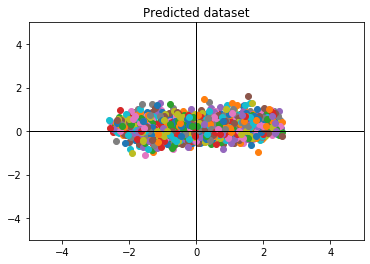

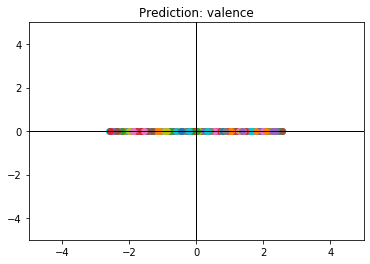

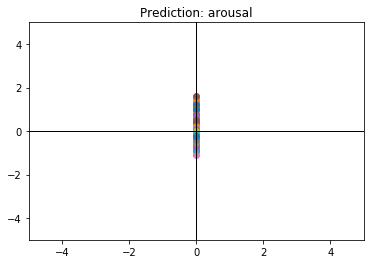

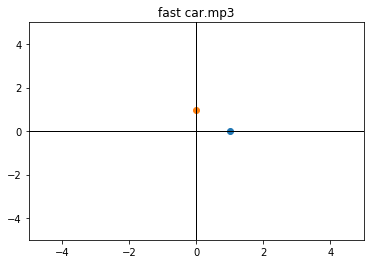

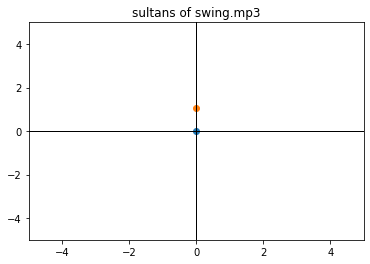

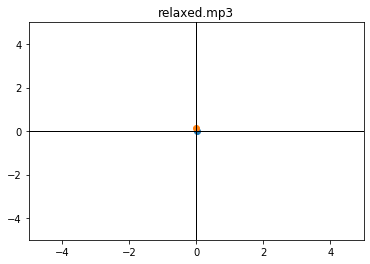

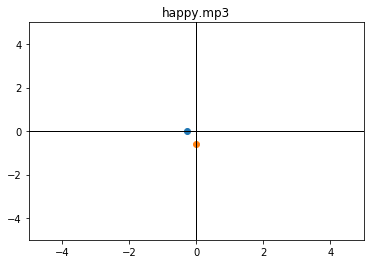

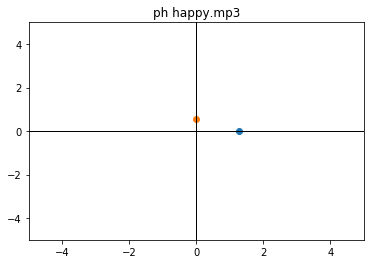

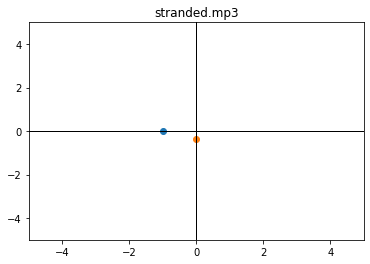

In [1]:
import librosa
import matplotlib.pyplot as plt
import librosa.display
import os
import pandas as pandas
from opt_einsum.backends import tensorflow
from sklearn.model_selection import train_test_split
from tensorflow import keras
import tensorflow as tf
import numpy
import csv
    
import warnings
warnings.filterwarnings("ignore")










# Preprocessing
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from keras import models
from keras import layers

def load(file): 
    y , sr = librosa.load(file, mono=True, duration = 10)

    onset_env = librosa.onset.onset_strength(y, sr=sr)
    out = {
        'filename': file,
        'arousal': 0,
        'valence': 0,
        #Mel-based Power Spectrogram
        'melspectrogram': numpy.mean(librosa.feature.melspectrogram(y=y, sr=sr)),
        #Tempo features
        'tempo': numpy.mean(librosa.beat.tempo(onset_envelope=onset_env, sr=sr)),
        'tempo_std': numpy.std(librosa.beat.tempo(onset_envelope=onset_env, sr=sr, aggregate=None)),
        
        # Zero Cross Rating
        'zcr': numpy.mean(librosa.feature.zero_crossing_rate(y)),
        'zcr_std': numpy.std(librosa.feature.zero_crossing_rate(y)),
        
        #Octave contrast std
        'spectral_contrast_std': numpy.std(librosa.feature.spectral_contrast(y=y, sr=sr))
    }
    
    #Extract all Mel-frequency cepstral coefficients 
    counter = 1
    for mfcc in (librosa.feature.mfcc(y=y, sr=sr)):
        out[('mfcc%s' % counter)] = numpy.mean(mfcc)
        counter = counter + 1
            
    #Chromagram of a Short Time Fourier Transform             
    counter = 1
    for chroma_stft in (librosa.feature.chroma_stft(y=y, sr=sr)):
        out[('chroma_stft%s' % counter)] = numpy.mean(chroma_stft)
        counter = counter + 1
    
    #Octave-based Spectral Contrast        
    counter = 1
    for spectral_contrast in (librosa.feature.spectral_contrast(y=y, sr=sr)):
        out[('spectral_contrast%s' % counter)] = numpy.mean(spectral_contrast)
        counter = counter + 1
        
    #Tonnetz        
    counter = 1
    for tonnetz in (librosa.feature.tonnetz(y=y, sr=sr)):
        out[('tonnetz%s' % counter)] = numpy.mean(tonnetz)
        counter = counter + 1
    
    return out

loaded = True
datafile = './data2.json'

import json
import numpy as np
import matplotlib.pyplot as plt

class NumpyEncoder(json.JSONEncoder):
    """ Special json encoder for numpy types """
    def default(self, obj):
        if isinstance(obj, (np.int_, np.intc, np.intp, np.int8,
            np.int16, np.int32, np.int64, np.uint8,
            np.uint16, np.uint32, np.uint64)):
            return int(obj)
        elif isinstance(obj, (np.float_, np.float16, np.float32, 
            np.float64)):
            return float(obj)
        elif isinstance(obj,(np.ndarray,)): #### This is the fix
            return obj.tolist()
        return json.JSONEncoder.default(self, obj)

def scale(oldmax, oldmin, newmax, newmin, oldvalue):
    newval = 0
    oldrange = (oldmax - oldmin)

    newrange = (newmax - newmin)  
    newval = (((oldvalue - oldmin) * newrange) / oldrange) + newmin
        
    return newval

def base(title):
    plt.figure()
    # Set x-axis range
    plt.xlim((-5,5))
    # Set y-axis range
    plt.ylim((-5,5))
    # Draw lines to split quadrants
    plt.plot([0,0],[-5,5], linewidth=1, color='black')
    plt.plot([5,-5],[0,0], linewidth=1, color='black')
    plt.title(title)
    
    return plt

scaling = { 'arousal': [], 'valence': [] }
    

def scatter(plt, arousal, valence):
    #Normalize input
    arousal = scale(scaling['arousal'][0], scaling['arousal'][1], 5, -5, arousal)        
    valence = scale(scaling['valence'][0], scaling['valence'][1], 5, -5, valence)
    
    plt.scatter(arousal, valence)


def scatterNoScale(plt, arousal, valence):
    #Normalize input
    if arousal is not 0:
        arousal = scale(scaling['arousal'][0], scaling['arousal'][1], 5, -5, arousal)
        
    if valence is not 0:
        valence = scale(scaling['valence'][0], scaling['valence'][1], 5, -5, valence)
    
    plt.scatter(arousal, valence)

def toEmotionIn(arousal, valence, song):    
    
    plt.figure()
    # Set x-axis range
    plt.xlim((-5,5))
    # Set y-axis range
    plt.ylim((-5,5))
    # Draw lines to split quadrants
    plt.plot([0,0],[-5,5], linewidth=1, color='black')
    plt.plot([5,-5],[0,0], linewidth=1, color='black')
    plt.scatter(valence, arousal)
    plt.title("Inverted: %s" % song)
    plt.show()

def toEmotion(arousal, valence, song):
    #Normalize input
    arousal = arousal -5;
    valence = valence -5;
    
    plt.figure()
    # Set x-axis range
    plt.xlim((-5,5))
    # Set y-axis range
    plt.ylim((-5,5))
    # Draw lines to split quadrants
    plt.plot([0,0],[-5,5], linewidth=1, color='black')
    plt.plot([5,-5],[0,0], linewidth=1, color='black')
    plt.scatter(arousal, valence)
    plt.title(song)
    plt.show()
    toEmotionIn(arousal, valence, song)
        
if not loaded:
    tracks = []
    basedir = './MEMD_audio'
    annotations = {'arousal': {}, 'valence': {}}

    def annotation(file):
        with open(file) as fh:
            rd = csv.DictReader(fh, delimiter=',')
            for row in rd:
                annotations['arousal']["%s.mp3" % row['song_id']] = row[' arousal_mean']
                annotations['valence']["%s.mp3" % row['song_id']] = row[' valence_mean']
            
    annotation('./annotations1.csv')
    annotation('./annotations2.csv')
    
    print(annotations)
    
    for track in os.listdir(basedir):   
        if len(tracks) < 2500:
            print(len(tracks))
            track_data = load(basedir + '/' + track)
            track_data['arousal'] = annotations['arousal'][track]
            track_data['valence'] = annotations['valence'][track]
            tracks.append(track_data)
    
    with open(datafile, 'w') as file_out:
        json.dump(tracks , file_out, cls=NumpyEncoder)
else:
    data = pandas.read_json(datafile)
    data = data.drop(['filename'],axis=1)
    x = data.iloc[:, 2:]   
    y = data.iloc[:, :2]
    
    scaling = {
        'arousal': [data.iloc[:, :1].min(), data.iloc[:, :1].max()],
        'valence': [data.iloc[:, 1:2].min(), data.iloc[:, 1:2].max()]
    }
    
    print(scaling)
        
    scalerX = StandardScaler()
    scalerY = StandardScaler()  
    x = (numpy.array(x, dtype = float))
    y = (numpy.array(y, dtype = float))
    
    x_train, x_test, y_train2, y_test2 = train_test_split(x, data.iloc[:, 1:2])
    x_train, x_test, y_train, y_test = train_test_split(x, data.iloc[:, :1])
    
    p = base("Current dataset")
    for sub in y:
        scatter(p, sub[0], sub[1])
    
    p.show()
    
    p = base("Dataset: X-axis (valence)")
    for sub in y:
        scatterNoScale(p, sub[0], 0)
    
    p.show()
    
    p = base("Dataset: Y-axis (arousal)")
    for sub in y:
        scatterNoScale(p, 0, sub[0])
    
    p.show()
    
    #import required packages
    from sklearn import neighbors
    from sklearn.metrics import mean_squared_error 
    from math import sqrt
    import matplotlib.pyplot as plt
    %matplotlib inline
    from sklearn.model_selection import GridSearchCV

    
    # rmse_val = [] #to store rmse values for different k
    # for K in range(20):
    #     K = K+1
    #     model = neighbors.KNeighborsRegressor(n_neighbors = K)
    # 
    #     model.fit(x_train, y_train)  #fit the model
    #     pred=model.predict(x_test) #make prediction on test set
    #     error = sqrt(mean_squared_error(y_test,pred)) #calculate rmse
    #     rmse_val.append(error) #store rmse values
    #     print('RMSE value for k= ' , K , 'is:', error)
    # 
    # #plotting the rmse values against k values
    # curve = pandas.DataFrame(rmse_val) #elbow curve 
    # curve.plot()
    # 
    # params = {'n_neighbors':[]}
    # for i in range(2, 20):
    #     params['n_neighbors'].append(i)
    #    
    #     
    # knn = neighbors.KNeighborsRegressor()
    # model = GridSearchCV(knn, params, cv=5)
    # model.fit(x_train,y_train)
    # print(model.best_params_)
    # 
    model = neighbors.KNeighborsRegressor(n_neighbors = 17)
    model.fit(x_train, y_train) 
    
    model2 = neighbors.KNeighborsRegressor(n_neighbors = 17)
    model2.fit(x_train, y_train2) 

    # predict = scalerX.fit_transform(numpy.array(model.predict(x_train), dtype = float))
    predict = model.predict(x_train)
    # predict2 = scalerX.fit_transform(numpy.array(model2.predict(x_train), dtype = float))
    predict2 = model2.predict(x_train)
    
    merged = np.concatenate((predict, predict2), axis=1)
    merged = merged

    p = base("Predicted dataset")
    for sub in merged:
        scatter(p, sub[0], sub[1]) 
    p.show()
    
    p = base("Prediction: valence")
    for sub in predict:
        scatterNoScale(p, sub[0], 0) 
    p.show()
    
    p = base("Prediction: arousal")
    for sub in predict2:
        scatterNoScale(p, 0, sub[0]) 
    p.show()
    
    files = ["fast car.mp3", "sultans of swing.mp3", "relaxed.mp3", "happy.mp3", "ph happy.mp3", "stranded.mp3"]
        
    def compute(file):
        loaded_data = load('./%s' % file)
        dataframe = pandas.DataFrame.from_dict(loaded_data, orient='index').T
        dataframe = dataframe.drop(['filename', 'arousal', 'valence'], axis=1)

        predictions = model.predict(dataframe)
        predictions2 = model2.predict(dataframe)
        
        print(predictions, predictions2)
        p = base(file)
        for sub in predictions:
            scatterNoScale(p, sub[0], 0) 

        for sub in predictions2:
            scatterNoScale(p, 0, sub[0]) 
        p.show()
        
            
    for file in files:
        compute(file)